In [151]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report,confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

In [152]:
x=pd.read_csv("X.csv")
y=pd.read_csv("Y.csv")
rifX=x
rifY=y["RIF"]

Concatenating features with labels

In [153]:
rifConcatenated=pd.concat([rifX,rifY],axis=1)

Checking duplicate rows

In [154]:
rifConcatenated.duplicated().value_counts()

False    2779
True      614
dtype: int64

Dropping Duplicate rows

In [155]:
rifConcatenated=rifConcatenated.drop_duplicates()
rifConcatenated.shape

(2779, 223)

Count of invalid labeled rows (label with -1 are invalid rows)

In [156]:
(rifConcatenated["RIF"]==-1).value_counts()

False    2725
True       54
Name: RIF, dtype: int64

Rows with invalid labels

In [157]:
invalidRows=rifConcatenated[rifConcatenated["RIF"]==-1]
invalidRows.index

Int64Index([ 313,  320,  346,  360,  381,  395,  397,  398,  403,  808, 1373,
            1586, 1588, 1706, 1715, 1717, 1800, 1857, 1902, 1945, 2190, 2355,
            2383, 2429, 2630, 2899, 2932, 2935, 3078, 3099, 3100, 3103, 3106,
            3109, 3112, 3118, 3125, 3128, 3131, 3135, 3139, 3155, 3189, 3214,
            3221, 3229, 3235, 3240, 3241, 3242, 3246, 3258, 3259, 3261],
           dtype='int64')

Dropping invalid labeled rows 

In [158]:
rifFiltered=rifConcatenated.drop(invalidRows.index)
rifFiltered.shape

(2725, 223)

Splitting the data into X and Y

In [159]:
rifX=rifFiltered.iloc[:,0:222]
rifY=rifFiltered.iloc[:,[222]]

In [160]:
rifX=rifX.replace(-1,0)

finding imbalance

1    1456
0    1269
Name: RIF, dtype: int64


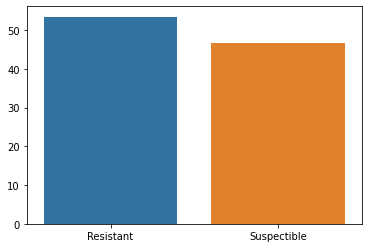

In [161]:
counts=rifFiltered['RIF'].value_counts()
print(counts)
proportions = counts / counts.sum()
proportions=proportions*100
sns.barplot(x=["Resistant","Suspectible"],y=proportions.values)
plt.show()

In [162]:
rifX_train,rifX_test,rifY_train,rifY_test=train_test_split(rifX,rifY,test_size=0.2,random_state=21)

## Feature Selection

Information gain

In [163]:
from sklearn.feature_selection import mutual_info_classif
information_gain_scores=mutual_info_classif(rifX_train,rifY_train)
information_gain_best_features_indices= information_gain_scores.argsort()[::-1][0:64]
infomation_gain_train=rifX_train.iloc[:,information_gain_best_features_indices]
infomation_gain_test=rifX_test.iloc[:,information_gain_best_features_indices]

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Chi square

In [164]:
from sklearn.feature_selection import SelectKBest,chi2
selector=SelectKBest(chi2,k=64)
chi_square_selected_features=selector.fit_transform(rifX_train,rifY_train)
chi_square_selected_features.shape
np.unique(selector.get_support(),return_counts=True)
# print(selector.get_support())
chi_square_train=rifX_train.iloc[:,selector.get_support()]
chi_square_test=rifX_test.iloc[:,selector.get_support()]

# Feature Extraction

PCA

In [165]:
from sklearn.decomposition import PCA
pca=PCA(n_components=64)
rifX_pca=pca.fit_transform(rifX)
pca_train,pca_test,pca_y_train,pca_y_test=train_test_split(rifX_pca,rifY,test_size=0.2,random_state=21)

ICA

In [166]:
from sklearn.decomposition import FastICA
ica=FastICA(n_components=64)
rifX_ica=ica.fit_transform(rifX)
ica_train,ica_test,ica_y_train,ica_y_test=train_test_split(rifX_pca,rifY,test_size=0.2,random_state=21)

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Auto encoders

In [167]:
input_data = Input(shape=(222,))
encoded = Dense(64, activation='relu')(input_data)
encoder = Model(input_data, encoded)
auto_enconder_data_train = encoder.predict(rifX_train)

input_data_t = Input(shape=(222,))
encoded_t = Dense(64, activation='relu')(input_data_t)
encoder_t = Model(input_data_t, encoded_t)
auto_enconder_data_test = encoder_t.predict(rifX_test)

18/18 [==============================] - 0s 1ms/step


### parameter tuning for random forest

In [168]:
# model1=RandomForestClassifier()
# param_grid = {
#     'n_estimators': [30,50, 100],
#     'max_depth': [None, 5, 10],
# }
# grid_search = GridSearchCV(model1, param_grid=param_grid, cv=5, n_jobs=-1,scoring='roc_auc',verbose=0)
# grid_search.fit(rifX, rifY)
# print(grid_search.best_params_)

### parameter tuning for svm

In [169]:
# model2=svm.SVC()
# param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
# grid_search = GridSearchCV(model2, param_grid, refit=True, verbose=0, cv=5,scoring='roc_auc')
# grid_search.fit(rifX, rifY)
# print(grid_search.best_params_)

### parameter tuning for BernoulliNB

In [170]:
# model4=BernoulliNB()
# param_grid = {'alpha': [0.1, 1, 10]}
# grid_search = GridSearchCV(model4, param_grid=param_grid, cv=5,scoring='roc_auc',verbose=0)
# grid_search.fit(rifX, rifY)
# print("Best hyperparameters:", grid_search.best_params_)

In [171]:
results=pd.DataFrame({"Algorithm":[],"Accuracy":[],"Precision":[],"F1 score":[],"Sensitivity":[],"Specificity":[],"AUC":[]})

In [172]:

def printResults(Algo,test_data,pred_data):
    global results
    print(Algo)
    print("--------------------")
    accuracy=accuracy_score(test_data,pred_data)
    F1_score=f1_score(test_data,pred_data)
    auc=roc_auc_score(test_data,pred_data)
    precision=precision_score(test_data,pred_data)
    sensitivity=recall_score(test_data,pred_data)
    specificity=1-sensitivity
    print("accuracy ",accuracy ,end=" , ")
    print("f1_score ", F1_score,end=" , ")
    print("auc ", auc)
    print("precision ",precision,end=" , ")
    print("sensitivity ",sensitivity,end=" , ")
    print("specificity ",1-sensitivity)
    # temp=pd.DataFrame({"Algorithm":[Algo],"Accuracy":[accuracy],"Precision":[precision],"F1 score":[F1_score],"Sensitivity":[sensitivity],"Specificity":[specificity],"AUC":[auc]})
    # print(temp)
    # results=results.concat({"Algorithm":Algo,"Accuracy":accuracy,"Precision":precision,"F1 score":F1_score,"Sensitivity":sensitivity,"Specificity":specificity,"AUC":auc},ignore_index=True)
    # ! temporary desable of confusion matrix
    # cm=(confusion_matrix(test_data,pred_data))
    # sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
    # plt.title("Confusion Matrix")
    # plt.xlabel("Predicted Label")
    # plt.ylabel("Actual Label")r
    # plt.show()
# accuracy  0.5009174311926605 , f1_score  0.6467532467532469 , auc  0.460477865968415
# precision  0.5331905781584583 , sensitivity  0.8217821782178217 , specificity  0.17821782178217827

Customise this input variables with features

In [173]:
input_X_train=pca_train
input_X_test=pca_test
input_Y_train=rifY_train
input_Y_test=rifY_test

In [174]:
rifX_train.shape

(2180, 222)

In [175]:
print(infomation_gain_train.shape)
print(infomation_gain_test.shape)

(2180, 64)
(545, 64)


# model1 (random forest)

In [176]:
rifModel1=RandomForestClassifier(n_estimators=50,max_depth=5)
rifModel1.fit(input_X_train,rifY_train)
rifPred=rifModel1.predict(input_X_test)
printResults("Random Forest",rifY_test,rifPred)

C:\Users\chandra sekhar\AppData\Local\Temp\ipykernel_9840\1159321004.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rifModel1.fit(input_X_train,rifY_train)


Random Forest
--------------------
accuracy  0.9247706422018349 , f1_score  0.930390492359932 , auc  0.9273518260917001
precision  0.958041958041958 , sensitivity  0.9042904290429042 , specificity  0.09570957095709576


### Random Forest(auto encoders features)

In [177]:
# rifModel1=RandomForestClassifier(n_estimators=50,max_depth=5)
# rifModel1.fit(auto_enconder_data_train,rifY_train)
# rifPred=rifModel1.predict(auto_enconder_data_test)
# printResults("Random Forest (auto encoder feature )",rifY_test,rifPred)

# model 2 (svm)

In [178]:
rifModel2=svm.SVC(kernel="linear",C= 0.1, gamma= 0.1)
rifModel2.fit(rifX_train,rifY_train)
rifPred=rifModel2.predict(rifX_test)
printResults("SVM",rifY_test,rifPred)

SVM
--------------------
accuracy  0.9596330275229358 , f1_score  0.9639344262295082 , auc  0.9582890107192537
precision  0.9576547231270358 , sensitivity  0.9702970297029703 , specificity  0.02970297029702973


c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM with Reduced_Data

In [179]:
# rifModel2=svm.SVC(kernel="linear",C= 0.1, gamma= 0.1)
# rifModel2.fit(auto_enconder_data_train,rifY_train)
# rifPred=rifModel2.predict(auto_enconder_data_test)
# printResults("SVM (auto encoder features)",rifY_test,rifPred)

svm with infomation gain features

In [180]:
# rifModel2=svm.SVC(kernel="linear",C= 0.1, gamma= 0.1)
# rifModel2.fit(infomation_gain_train,rifY_train)
# rifPred=rifModel2.predict(infomation_gain_test)
# printResults("SVM (info gain features)",rifY_test,rifPred)

# model 3 (Logistic regression)

In [181]:
rifModel3=LogisticRegression()
rifModel3.fit(rifX_train,rifY_train)
rifPred=rifModel3.predict(rifX_test)
printResults("Logistic Regression",rifY_test,rifPred)

Logistic Regression
--------------------
accuracy  0.9596330275229358 , f1_score  0.9638157894736842 , auc  0.9587049614052314
precision  0.9606557377049181 , sensitivity  0.966996699669967 , specificity  0.03300330033003296


c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# model4 (bernoulliNB)


In [182]:
rifModel4=BernoulliNB(alpha=10)
rifModel4.fit(rifX_train,rifY_train)
rifPred=rifModel4.predict(rifX_test)
printResults("BernoulliNB",rifY_test,rifPred)

BernoulliNB
--------------------
accuracy  0.8935779816513761 , f1_score  0.9010238907849829 , auc  0.8963873660093281
precision  0.9328621908127208 , sensitivity  0.8712871287128713 , specificity  0.12871287128712872


c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Feed Forward Neural Networks

In [183]:
X_train, X_test, Y_train, Y_test = train_test_split(rifX, rifY, test_size=0.2, random_state=22)
def nnModel(optimizer):
    model = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.4),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
keras_classfier=KerasClassifier(build_fn=nnModel,verbose=0)
param_grid={
    "batch_size":[16,32],
    "epochs":[5,10,15],
    "optimizer":["adam","adagrad","rmsprop","sgd"]
}

grid_search=GridSearchCV(estimator=keras_classfier,param_grid=param_grid,cv=5)
grid_search.fit(X_train,Y_train)
grid_search.best_params_
grid_search.best_params_
y_pred = grid_search.predict(X_test)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions

printResults("Neural Networks",Y_test,y_pred_binary)

C:\Users\chandra sekhar\AppData\Local\Temp\ipykernel_9840\1301348187.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classfier=KerasClassifier(build_fn=nnModel,verbose=0)


18/18 [==============================] - 0s 1ms/step
Neural Networks
--------------------
accuracy  0.9486238532110092 , f1_score  0.9512195121951219 , auc  0.9479208801876872
precision  0.934931506849315 , sensitivity  0.9680851063829787 , specificity  0.03191489361702127


# 1D CNN

In [184]:
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, Flatten

inputs = Input(shape=(64,1))
x = Conv1D(32, 2, padding='same', activation='elu')(inputs)
x = Conv1D(64, 2, padding='same', activation='elu')(x)
x = Flatten()(x)
x = Dense(64, activation='elu')(x)
x = Dense(32, activation='elu')(x)
x = Dense(16, activation='elu')(x)
x = Dense(2, activation='linear')(x)
model = Model(inputs=[inputs], outputs=[x])
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['acc'])
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 64, 1)]           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 64, 32)            96        
                                                                 
 conv1d_11 (Conv1D)          (None, 64, 64)            4160      
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_1843 (Dense)          (None, 64)                262208    
                                                                 
 dense_1844 (Dense)          (None, 32)                2080      
                                                                 
 dense_1845 (Dense)          (None, 16)                528

In [185]:
from keras.utils import np_utils
input_Y_train_1dCNN = np_utils.to_categorical(
    rifY_train, num_classes=2
)

In [186]:
print(input_X_train.shape)

(2180, 64)


In [187]:
model.fit(x=input_X_train,y=input_Y_train_1dCNN,batch_size=4,epochs=20)
rifPred=model.predict(input_X_test)
rifPred=np.argmax(rifPred,axis=1)
# print(rifPred)
printResults("1D CNN",input_Y_test,rifPred)

Epoch 1/20


545/545 [==============================] - 3s 4ms/step - loss: 0.5132 - acc: 0.9124
Epoch 2/20
545/545 [==============================] - 2s 4ms/step - loss: 0.3505 - acc: 0.9330
Epoch 3/20
545/545 [==============================] - 2s 4ms/step - loss: 0.2986 - acc: 0.9427
Epoch 4/20
545/545 [==============================] - 2s 4ms/step - loss: 0.2780 - acc: 0.9440
Epoch 5/20
545/545 [==============================] - 2s 4ms/step - loss: 0.2800 - acc: 0.9422
Epoch 6/20
545/545 [==============================] - 2s 5ms/step - loss: 0.2434 - acc: 0.9463
Epoch 7/20
545/545 [==============================] - 2s 4ms/step - loss: 0.2389 - acc: 0.9463
Epoch 8/20
545/545 [==============================] - 2s 4ms/step - loss: 0.2289 - acc: 0.9436
Epoch 9/20
545/545 [==============================] - 2s 4ms/step - loss: 0.2038 - acc: 0.9491
Epoch 10/20
545/545 [==============================] - 2s 4ms/step - loss: 0.1899 - acc: 0.9477
Epoch 11/20
545/545 [==============================] - 2s 4m

In [188]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# model5 (GradientBoosting)

In [189]:
rifModel5=GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 100)
rifModel5.fit(rifX_train,rifY_train)
rifPred=rifModel5.predict(rifX_test)
printResults("GradientBoostingClassifier",rifY_test,rifPred)

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier
--------------------
accuracy  0.9669724770642202 , f1_score  0.9704918032786886 , auc  0.9657215721572158
precision  0.9641693811074918 , sensitivity  0.976897689768977 , specificity  0.02310231023102305


# model6 (Ada Boost)

In [190]:
rifModel6=AdaBoostClassifier(n_estimators=50, base_estimator=svm.SVC(probability=True, kernel='linear'),learning_rate=1)
rifModel6.fit(rifX_train,rifY_train)
rifPred=rifModel6.predict(rifX_test)
printResults("Ada Boost Classifier forest",rifY_test,rifPred)

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Ada Boost Classifier forest
--------------------
accuracy  0.8587155963302753 , f1_score  0.8855869242199109 , auc  0.8429888443389794
precision  0.8054054054054054 , sensitivity  0.9834983498349835 , specificity  0.01650165016501648



# model7 (XG-Boosting)

In [191]:
# rifModel7= xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3, enable_categorical=True)
# rifModel7.fit(X_train, y_train)

# rifModel7.fit(rifX_train,rifY_train)
# rifPred=rifModel7.predict(rifX_test)
# print("XGBoost Classifier")
# print("--------------------")
# print("accuracy ", accuracy_score(rifY_test,rifPred))
# print("f1_score ", f1_score(rifY_test,rifPred))
# print("auc ", roc_auc_score(rifY_test,rifPred))
# print("precision ",precision_score(rifY_test,rifPred))
# print("sensitivity ",recall_score(rifY_test,rifPred))
# print("specificity ",1-recall_score(rifY_test,rifPred))
# cm=(confusion_matrix(rifY_test,rifPred))
# sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("Actual Label")
# plt.show()

In [192]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# def iterative_xgboost_classifier(num, alpha, rifX_train, rifY_train, rifX_test, rifY_test):
#     base_learners = []
#     target = rifY_train.copy()

#     for _ in range(num):
#         xgb_classifier = XGBClassifier(
#             n_estimators=1,  # Using a single decision tree as the base learner
#             objective='binary:logistic',
#             tree_method='hist',
#             learning_rate=alpha,
#             max_depth=3,
#             enable_categorical=True,
#             base_score=np.mean(target)  # Initial prediction based on class distribution
#         )
#         xgb_classifier.fit(rifX_train, target)
#         xgb_predictions = xgb_classifier.predict(rifX_train)
#         target -= (alpha * xgb_predictions).astype(np.int64)
#         base_learners.append(xgb_classifier)

#     y_pred = np.zeros_like(rifY_test, dtype=np.float64)

#     for xgb_classifier in base_learners:
#         y_pred += alpha * xgb_classifier.predict(rifX_test)

#     y_pred_class = (y_pred >= 0.5)

#     print("Iterative XGBoost Classifier with {} Decision Trees and Learning Rate of {}".format(num, alpha))
#     print("--------------------")
#     accuracy = accuracy_score(rifY_test, y_pred_class)
#     print(f"Accuracy: {accuracy:.2f}")
#     print("f1_score: ", f1_score(rifY_test, y_pred_class))
#     print("auc: ", roc_auc_score(rifY_test, y_pred_class))
#     print("precision: ", precision_score(rifY_test, y_pred_class))
#     print("sensitivity: ", recall_score(rifY_test, y_pred_class))
#     print("specificity: ", 1 - recall_score(rifY_test, y_pred_class))
#     cm = confusion_matrix(rifY_test, y_pred_class)
#     sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
#     plt.title("Confusion Matrix for XGBoost")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("Actual Label")
#     plt.show()

# # Example usage:
# iterative_xgboost_classifier(50, 0.1, rifX_train, rifY_train, rifX_test, rifY_test)


# evaluating using cross_validation_score with folds=30

In [193]:
# from sklearn.model_selection import cross_val_score

In [194]:
# print("Random Forest")
# aucScores=cross_val_score(rifModel1, rifX, rifY, cv=30, scoring="roc_auc")
# f1Scores = cross_val_score(rifModel1, rifX, rifY, cv=30, scoring='f1')
# print("Mean f1_score ",f1Scores.mean())
# print("Mean auc ",aucScores.mean())

In [195]:
# print("SVM")
# aucScores=cross_val_score(rifModel2, rifX, rifY, cv=30, scoring="roc_auc")
# f1Scores = cross_val_score(rifModel2, rifX, rifY, cv=30, scoring='f1')
# print("Mean f1_score ",f1Scores.mean())
# print("Mean auc ",aucScores.mean())

In [196]:
# print("Logistic Regression")
# aucScores=cross_val_score(rifModel3, rifX, rifY, cv=20, scoring="roc_auc")
# f1Scores = cross_val_score(rifModel3, rifX, rifY, cv=20, scoring='f1')
# print("Mean f1_score ",f1Scores.mean())
# print("Mean auc ",aucScores.mean())
# # print(aucScores)

In [197]:
# print("BernoulliNB")
# aucScores=cross_val_score(rifModel4, rifX, rifY, cv=30, scoring="roc_auc")
# f1Scores = cross_val_score(rifModel4, rifX, rifY, cv=30, scoring='f1')
# print("Mean f1_score ",f1Scores.mean())
# print("Mean auc ",aucScores.mean())
# # print(aucScores)